In [111]:
# Solar Energy Forecasting – Fundamentals of Data Analytics Assignment

#Student Name: Ismail Tuna Gürbüz 
#Course: MS Fundamentals of Data Analytics  


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#In this section, I installed the libraries as the first step.

In [4]:
from datetime import datetime # Used for handling and working with date and time objects
from sklearn.model_selection import train_test_split  # Used to split the dataset into training and testing sets
from sklearn.linear_model import LinearRegression     # Linear regression model used as a baseline forecasting approach
from sklearn.ensemble import RandomForestRegressor    # Ensemble-based regression model capable of capturing non-linear relationships
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error   # Evaluation metrics used to assess model performance

In [6]:
df = pd.read_excel(r'D:\Desktop\solar_weather - Raw - Assignment Oct 2025.xlsx')

In [7]:
df.head()

,Time,Energy Captured[Wh],Sun Light Intensity (W/m2),Temperature,1 Hour Rain Fall,Cloud Coverage,Length of Day_Light
0,2017-01-01 00:00:00,0,0,1.6,0,100,450
1,2017-01-01 00:15:00,0,0,1.6,0,100,450
2,2017-01-01 00:30:00,0,0,1.6,0,100,450
3,2017-01-01 00:45:00,0,0,1.6,0,100,450
4,2017-01-01 01:00:00,0,0,1.7,0,100,450


In [8]:
df.describe()

,Time,Energy Captured[Wh],Sun Light Intensity (W/m2),Temperature,1 Hour Rain Fall,Cloud Coverage,Length of Day_Light
count,196777,196777,196777,196777.0,196777,196777,196777
unique,196769,4558,2279,504.0,313,106,40
top,NAN,0,0,4.8,0,100,1020
freq,8,100855,95046,1500.0,171805,49473,16416


In [9]:
df.tail()

,Time,Energy Captured[Wh],Sun Light Intensity (W/m2),Temperature,1 Hour Rain Fall,Cloud Coverage,Length of Day_Light
196772,2022-08-31 16:45:00,118,23.7,18.6,0,52,825
196773,2022-08-31 17:00:00,82,15.6,18.5,0,60,825
196774,2022-08-31 17:15:00,51,8,18.5,0,60,825
196775,2022-08-31 17:30:00,24,2.1,18.5,0,60,825
196776,2022-08-31 17:45:00,0,0,18.5,0,60,825


In [10]:
df.shape

(196777, 7)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196777 entries, 0 to 196776
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Time                        196777 non-null  object
 1   Energy Captured[Wh]         196777 non-null  object
 2   Sun Light Intensity (W/m2)  196777 non-null  object
 3   Temperature                 196777 non-null  object
 4   1 Hour Rain Fall            196777 non-null  object
 5   Cloud Coverage              196777 non-null  object
 6   Length of Day_Light         196777 non-null  object
dtypes: object(7)
memory usage: 10.5+ MB


In [12]:
df.columns


Index(['Time', 'Energy Captured[Wh]', 'Sun Light Intensity (W/m2)',
       'Temperature', '1 Hour Rain Fall', 'Cloud Coverage',
       'Length of Day_Light'],
      dtype='object')

In [14]:
df.columns = [
    'time',
    'energy',
    'sunlight',
    'temperature',
    'rainfall',
    'cloud_cover',
    'daylight_length'
]
#Column names were simplified to improve readability and ease of analysis.

In [15]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')
#Invalid or improperly formatted timestamps were converted to missing values

In [16]:
numeric_cols = df.columns.drop('time')

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
#The reason I'm doing this is because our data is raw and string numbers cannot enter the model. Corrupted values ​​will be NaN → checkable.

In [17]:
df.isnull().sum()


time                8
energy              4
sunlight            7
temperature         6
rainfall            4
cloud_cover        13
daylight_length     5
dtype: int64

In [18]:
#The number of missing values is very small compared to the overall dataset size and is therefore considered low severity

In [19]:
df = df.dropna(subset=['time'])


In [20]:
#Rows with missing timestamps were removed as they cannot be positioned in the time series.

In [21]:
df = df.sort_values('time')
df = df.set_index('time')


In [22]:
#The temporal order of observations was preserved to maintain the integrity of the time series.

In [23]:
# Check if there are duplicate timestamps (important for time series integrity)
duplicate_times = df.index.duplicated().sum()
print("Duplicate timestamps:", duplicate_times)

# If duplicates exist, keep the first occurrence (simple and acceptable for student work)
df = df[~df.index.duplicated(keep='first')]


Duplicate timestamps: 1


In [25]:
# Remove rows with missing timestamps 
df = df.dropna(subset=['time']) if 'time' in df.columns else df


In [26]:
#  Rows without a valid timestamp cannot be positioned on the timeline, so they are removed.

In [27]:
# Fill small number of missing values using time-based interpolation
df = df.interpolate(method='time')

# If any missing values still remain at the edges, forward/backward fill them
df = df.ffill().bfill()

# Final missing check
print(df.isnull().sum())


energy             0
sunlight           0
temperature        0
rainfall           0
cloud_cover        0
daylight_length    0
dtype: int64


In [28]:
# Objective: To ensure the completeness of the dataset, I filled in small missing gaps using time-based interpolation and completed the remaining missing edge values ​​using backfill/forward padding.

In [30]:
print(df.dtypes)


energy             float64
sunlight           float64
temperature        float64
rainfall           float64
cloud_cover        float64
daylight_length    float64
dtype: object


In [31]:
print(type(df.index))
print(df.index.min(), df.index.max())


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
2017-01-01 00:00:00 2022-08-31 17:45:00


In [32]:
# Purpose: I verified that the dataset index is a DatetimeIndex and confirmed the overall time range of the observations (2017–2022), which is essential for time series analysis.


In [33]:
# I check for negative energy values (not physically meaningful)
(df['energy'] < 0).sum()


np.int64(1)

In [34]:
# I replace negative energy values with 0 because energy production cannot be negative
df.loc[df['energy'] < 0, 'energy'] = 0


In [35]:
# Purpose: I corrected a small measurement error by setting negative energy values to zero, since solar energy production cannot be negative.


In [36]:
(df['cloud_cover'] < 0).sum(), df['cloud_cover'].min()


(np.int64(2), -250.0)

In [37]:
# I correct unrealistic cloud cover values by limiting them to the range 0–100
df['cloud_cover'] = df['cloud_cover'].clip(lower=0, upper=100)


In [38]:
# Purpose: I fixed physically impossible cloud cover values to improve data quality before analysis.


In [39]:
(df['cloud_cover'] < 0).sum(), df['cloud_cover'].min(), df['cloud_cover'].max()


(np.int64(0), 0.0, 100.0)

In [40]:
# I correct negative energy values
df.loc[df['energy'] < 0, 'energy'] = 0


In [41]:
# I check for unrealistic cloud cover values
print("Negative cloud cover:", (df['cloud_cover'] < 0).sum())
print("Max cloud cover:", df['cloud_cover'].max())


Negative cloud cover: 0
Max cloud cover: 100.0


In [43]:
df.describe()


,energy,sunlight,temperature,rainfall,cloud_cover,daylight_length
count,196768.000000,196768.000000,196768.000000,196768.000000,196768.000000,196768.000000
mean,573.025723,32.598761,9.790877,0.066038,65.973075,748.655727
std,1044.841739,52.175577,7.995389,0.278919,36.629504,194.865992
min,0.000000,0.000000,-16.600000,0.000000,0.000000,450.000000
25%,0.000000,0.000000,3.600000,0.000000,34.000000,570.000000
50%,0.000000,1.600000,9.300000,0.000000,82.000000,765.000000
75%,577.000000,46.800000,15.700000,0.000000,100.000000,930.000000
max,5020.000000,270.000000,35.800000,8.090000,100.000000,1020.000000


In [46]:
# I perform a final sanity check for unrealistic values in numerical columns

checks = {
    "negative_energy": (df['energy'] < 0).sum(),
    "negative_sunlight": (df['sunlight'] < 0).sum(),
    "negative_rainfall": (df['rainfall'] < 0).sum(),
    "negative_cloud_cover": (df['cloud_cover'] < 0).sum(),
    "cloud_cover_above_100": (df['cloud_cover'] > 100).sum()
}

checks


{'negative_energy': np.int64(0),
 'negative_sunlight': np.int64(0),
 'negative_rainfall': np.int64(0),
 'negative_cloud_cover': np.int64(0),
 'cloud_cover_above_100': np.int64(0)}

In [47]:
#A final sanity check was performed to ensure that no physically unrealistic values remained in the numerical variables. No negative energy, sunlight, rainfall, or cloud cover values were found, and all cloud cover values were within the valid range of 0–100.

In [48]:
# I calculate descriptive statistics (mean, median, mode, standard deviation) for each variable

stats_df = pd.DataFrame({
    "Mean": df.mean(),
    "Median": df.median(),
    "Mode": df.mode().iloc[0],
    "Standard Deviation": df.std()
})

stats_df


,Mean,Median,Mode,Standard Deviation
energy,573.025723,0.0,0.0,1044.841739
sunlight,32.598761,1.6,0.0,52.175577
temperature,9.790877,9.3,4.8,7.995389
rainfall,0.066038,0.0,0.0,0.278919
cloud_cover,65.973075,82.0,100.0,36.629504
daylight_length,748.655727,765.0,1020.0,194.865992


In [49]:
# Purpose: I summarise the typical values and variability of each variable to better understand the data before modelling.


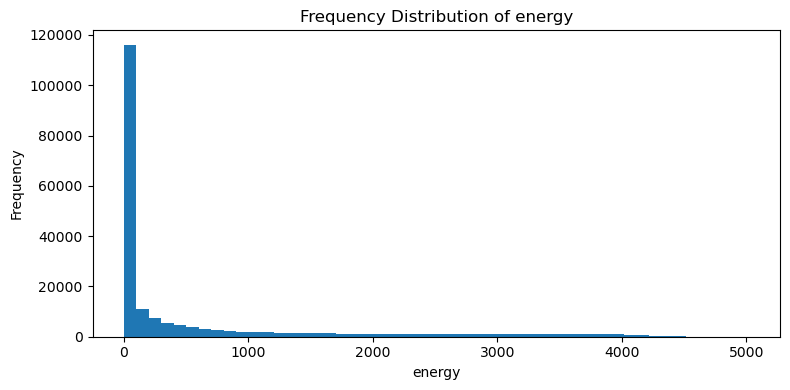

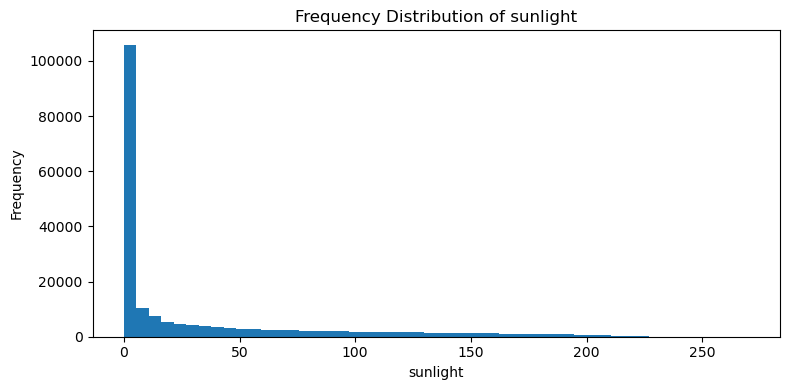

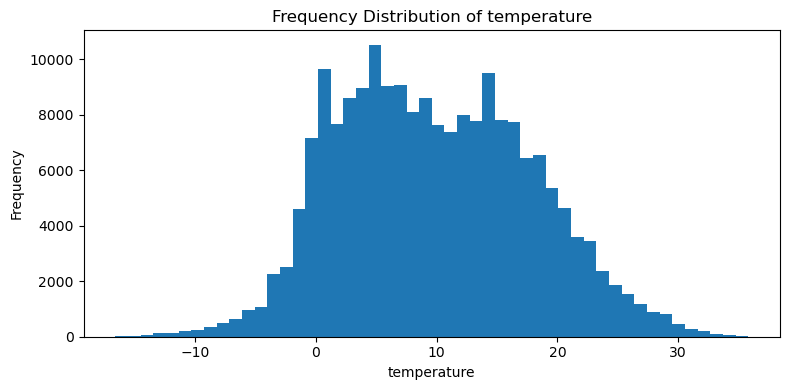

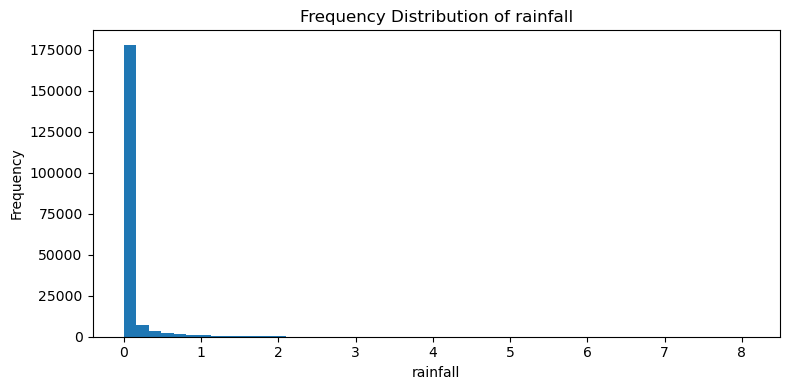

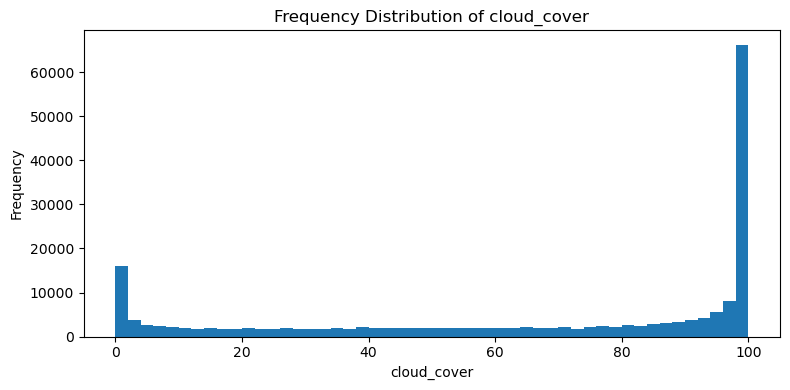

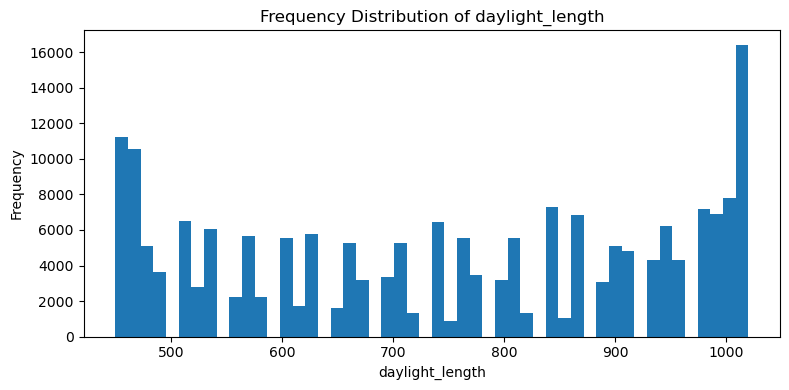

In [50]:
# I plot frequency distribution charts to understand how the values of each variable are spread

for col in df.columns:
    plt.figure(figsize=(8, 4))
    plt.hist(df[col], bins=50)
    plt.title(f"Frequency Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


In [51]:
# I calculate the correlation matrix between all numerical variables
correlation_matrix = df.corr()
correlation_matrix


,energy,sunlight,temperature,rainfall,cloud_cover,daylight_length
energy,1.000000,0.914572,0.378547,-0.059885,-0.190217,0.280684
sunlight,0.914572,1.000000,0.492676,-0.048578,-0.188760,0.401049
temperature,0.378547,0.492676,1.000000,0.073818,-0.117222,0.706495
rainfall,-0.059885,-0.048578,0.073818,1.000000,0.173327,0.048417
cloud_cover,-0.190217,-0.188760,-0.117222,0.173327,1.000000,-0.234911
daylight_length,0.280684,0.401049,0.706495,0.048417,-0.234911,1.000000


In [52]:
#  I compute correlations to measure how strongly the variables move together.


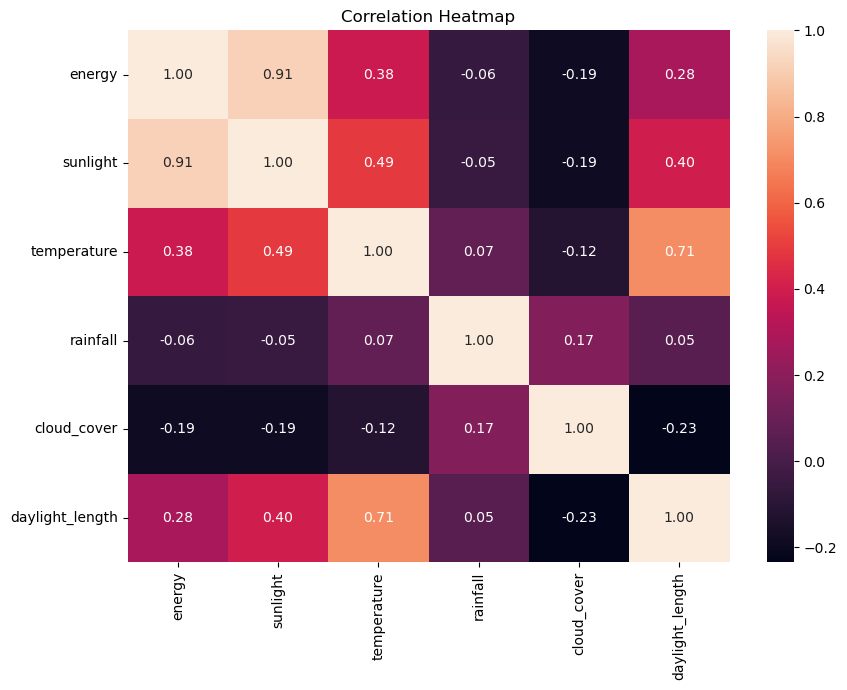

In [53]:
# I visualise the correlation matrix using a heatmap

plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


<Axes: >

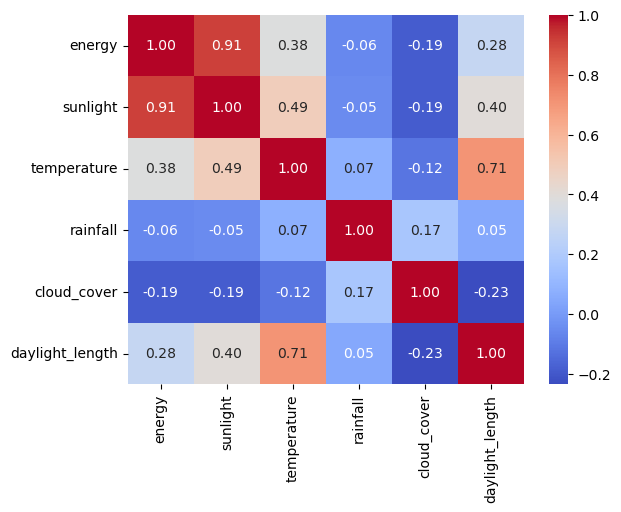

In [54]:
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")


In [56]:
#  I use a heatmap to clearly see positive and negative relationships between variables.


In [57]:
#Task 3: Model Development and Evaluation (LO1, LO2 and LO3)

In [58]:
#Sunlight has the strongest positive correlation with energy production, which is logically correct because solar panels directly depend on sunlight intensity.

In [59]:
#Temperature and daylight length also show positive correlations, reflecting seasonal effects and longer production periods during summer.

In [60]:
#Cloud cover has a negative correlation with energy, which makes sense as clouds reduce solar radiation.

In [61]:
#Rainfall shows very weak correlation, indicating limited direct impact on energy generation.

In [62]:
features = ['sunlight', 'temperature', 'cloud_cover', 'daylight_length', 'rainfall']
target = 'energy'

X = df[features]
y = df[target]


In [63]:
#  I select the most relevant weather variables to predict solar energy production.


In [70]:
features = ['sunlight', 'temperature', 'cloud_cover', 'daylight_length', 'rainfall']
target = 'energy'

X = df[features]
y = df[target]


In [71]:
#  I select the most relevant weather variables to predict solar energy production.


In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [73]:
#  I split the dataset into training and testing sets to evaluate model performance on unseen data.


In [74]:
# Model 1 Lineer Regression 

In [75]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)


In [76]:
#  I train a Linear Regression model to establish a simple baseline prediction.


In [77]:
# Model 2 – Random Forest Regressor

In [78]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)


In [79]:
#  I train a Random Forest model to capture non-linear relationships in the data.


In [80]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    print(f"{model_name} Evaluation:")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print("-" * 30)

    return r2, mae, mse

lr_metrics = evaluate_model(y_test, y_pred_lr, "Linear Regression")
rf_metrics = evaluate_model(y_test, y_pred_rf, "Random Forest")


Linear Regression Evaluation:
R2 Score: 0.8454
MAE: 242.51
MSE: 170527.57
------------------------------
Random Forest Evaluation:
R2 Score: 0.9159
MAE: 131.89
MSE: 92705.96
------------------------------


In [81]:
# I make sure the data is sorted by time (time series order)
df = df.sort_index()


In [84]:
#  I ensure the dataset is ordered chronologically before time-based splitting.# I define features and target again for the time-based split
features = ['sunlight', 'temperature', 'cloud_cover', 'daylight_length', 'rainfall']
target = 'energy'

X = df[features]
y = df[target]



In [85]:
# I split the dataset by time: first 80% for training, last 20% for testing
split_index = int(len(df) * 0.8)

X_train_t = X.iloc[:split_index]
X_test_t  = X.iloc[split_index:]

y_train_t = y.iloc[:split_index]
y_test_t  = y.iloc[split_index:]


In [86]:
#  I use the last 20% of the timeline as a test set to simulate forecasting on future data.


In [88]:
# I train Linear Regression using the time-based split
lr_model_t = LinearRegression()
lr_model_t.fit(X_train_t, y_train_t)

y_pred_lr_t = lr_model_t.predict(X_test_t)


In [89]:
# I train Random Forest using the time-based split
rf_model_t = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_t.fit(X_train_t, y_train_t)

y_pred_rf_t = rf_model_t.predict(X_test_t)


In [91]:
# I evaluate both models on the time-based test set
evaluate_model(y_test_t, y_pred_lr_t, "Linear Regression (time-based)")
evaluate_model(y_test_t, y_pred_rf_t, "Random Forest (time-based)")


Linear Regression (time-based) Evaluation:
R2 Score: 0.8241
MAE: 261.62
MSE: 192633.72
------------------------------
Random Forest (time-based) Evaluation:
R2 Score: 0.8805
MAE: 158.30
MSE: 130835.85
------------------------------


(0.88054917984653, 158.30376749894108, 130835.84701488001)

In [92]:
# I apply a different train-test split ratio (70/30)

X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [93]:
# Purpose: I test how changing the split ratio affects model performance.


In [94]:
#Linear Regression (70/30)

In [95]:
lr_model_70 = LinearRegression()
lr_model_70.fit(X_train_70, y_train_70)

y_pred_lr_70 = lr_model_70.predict(X_test_70)


In [96]:
#Random Forest (70/30)

In [97]:
rf_model_70 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_70.fit(X_train_70, y_train_70)

y_pred_rf_70 = rf_model_70.predict(X_test_70)


In [98]:
evaluate_model(y_test_70, y_pred_lr_70, "Linear Regression (70/30 split)")
evaluate_model(y_test_70, y_pred_rf_70, "Random Forest (70/30 split)")


Linear Regression (70/30 split) Evaluation:
R2 Score: 0.8458
MAE: 242.64
MSE: 169343.12
------------------------------
Random Forest (70/30 split) Evaluation:
R2 Score: 0.9145
MAE: 133.27
MSE: 93938.60
------------------------------


(0.9144555631035716, 133.2698874072254, 93938.59665374926)

In [99]:
# I store the evaluation results for later comparison
lr_metrics_70 = evaluate_model(y_test_70, y_pred_lr_70, "Linear Regression (70/30 split)")
rf_metrics_70 = evaluate_model(y_test_70, y_pred_rf_70, "Random Forest (70/30 split)")


Linear Regression (70/30 split) Evaluation:
R2 Score: 0.8458
MAE: 242.64
MSE: 169343.12
------------------------------
Random Forest (70/30 split) Evaluation:
R2 Score: 0.9145
MAE: 133.27
MSE: 93938.60
------------------------------


In [101]:
# My Purpose: I save the metric values so I can compare split ratios more easily.


# Graph for  (Random split 80/20)

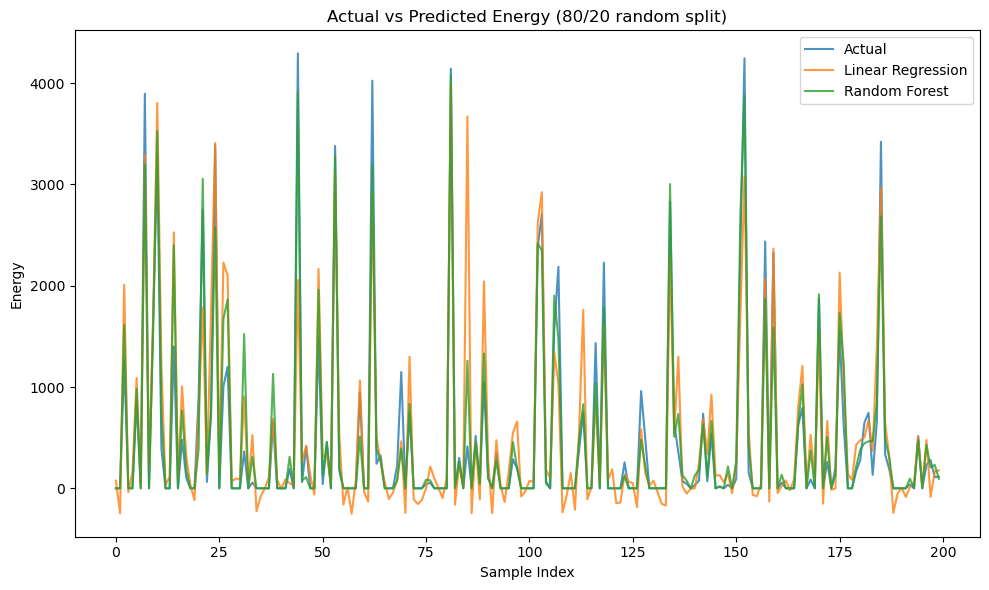

In [102]:
# I compare actual values with both model predictions (random split)

plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:200], label="Actual", alpha=0.8)
plt.plot(y_pred_lr[:200], label="Linear Regression", alpha=0.8)
plt.plot(y_pred_rf[:200], label="Random Forest", alpha=0.8)
plt.title("Actual vs Predicted Energy (80/20 random split)")
plt.xlabel("Sample Index")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()


In [103]:
# Summary Table (Split vs Model vs Metrics)

In [104]:
# I create a simple summary table to compare models across different split strategies . 

summary_results = pd.DataFrame([
    {"Split": "Random 80/20", "Model": "Linear Regression", "R2": 0.8454, "MAE": 242.51, "MSE": 170527.57},
    {"Split": "Random 80/20", "Model": "Random Forest",     "R2": 0.9159, "MAE": 131.89, "MSE":  92705.96},

    {"Split": "Random 70/30", "Model": "Linear Regression", "R2": 0.8458, "MAE": 242.64, "MSE": 169343.12},
    {"Split": "Random 70/30", "Model": "Random Forest",     "R2": 0.9145, "MAE": 133.27, "MSE":  93938.60},

    {"Split": "Time-based 80/20", "Model": "Linear Regression", "R2": 0.8241, "MAE": 261.62, "MSE": 192633.72},
    {"Split": "Time-based 80/20", "Model": "Random Forest",     "R2": 0.8805, "MAE": 158.30, "MSE": 130835.85},
])

summary_results


,Split,Model,R2,MAE,MSE
0,Random 80/20,Linear Regression,0.8454,242.51,170527.57
1,Random 80/20,Random Forest,0.9159,131.89,92705.96
2,Random 70/30,Linear Regression,0.8458,242.64,169343.12
3,Random 70/30,Random Forest,0.9145,133.27,93938.60
4,Time-based 80/20,Linear Regression,0.8241,261.62,192633.72
5,Time-based 80/20,Random Forest,0.8805,158.30,130835.85


In [106]:
#  I summarise the evaluation results in one table to make model comparison easier.


In [107]:
# Time-based Split Graph (Actual vs Predictions)

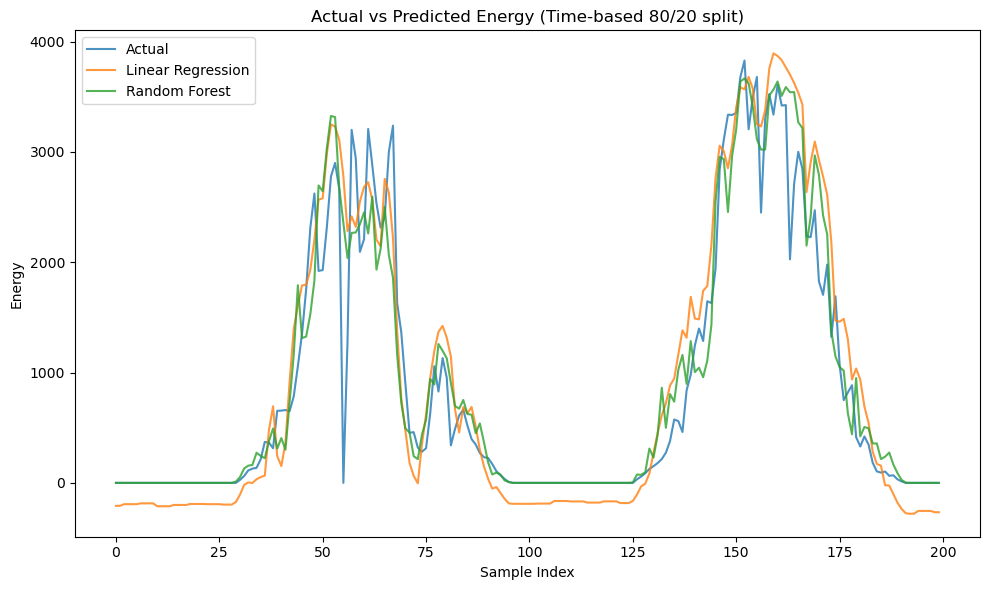

In [108]:
# I plot the actual values and both model predictions for the time-based test set

plt.figure(figsize=(10, 6))

plt.plot(y_test_t.values[:200], label="Actual", alpha=0.8)
plt.plot(y_pred_lr_t[:200], label="Linear Regression", alpha=0.8)
plt.plot(y_pred_rf_t[:200], label="Random Forest", alpha=0.8)

plt.title("Actual vs Predicted Energy (Time-based 80/20 split)")
plt.xlabel("Sample Index")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()


In [109]:
#  I compare the models under a realistic forecasting setting using a time-based split.


In [113]:
### Task 3 Results and Discussion

#Both models successfully capture the general pattern of solar energy production. However, the Random Forest model consistently achieves higher R² values and lower MAE and MSE across all splitting strategies.

#The prediction graphs also show that Random Forest follows peak production periods more closely, while Linear Regression tends to underestimate high values.

#Based on the results, I consider Random Forest to be the more reliable model for this dataset, especially for forecasting future energy production under varying weather conditions.

#During this task, I also realised how important proper data splitting is for evaluating real-world model performance.


In [114]:
# Task 4 – Step 1: Final model selection (Random Forest)

In [115]:
# I select Random Forest as the final model because it achieved the best performance
final_model = rf_model_t


In [116]:
# Purpose: I use the most accurate model for future energy forecasting.


In [117]:
#Task 4 – Step 2: Filter January data (2017–2022)

In [118]:
# I filter only January data from the dataset
january_data = df[df.index.month == 1]

january_data.head()


,energy,sunlight,temperature,rainfall,cloud_cover,daylight_length
time,,,,,,
2017-01-01 00:00:00,0.0,0.0,1.6,0.0,100.0,450.0
2017-01-01 00:15:00,0.0,0.0,1.6,0.0,100.0,450.0
2017-01-01 00:30:00,0.0,0.0,1.6,0.0,100.0,450.0
2017-01-01 00:45:00,0.0,0.0,1.6,0.0,100.0,450.0
2017-01-01 01:00:00,0.0,0.0,1.7,0.0,100.0,450.0


In [119]:
# I filter January data for specific years (2017–2022)
january_years = january_data[
    (january_data.index.year >= 2017) &
    (january_data.index.year <= 2022)
]

january_years['energy'].groupby(january_years.index.year).mean()


time
2017    180.285169
2018    125.422715
2019    117.248992
2020    122.447245
2021     83.167339
2022    161.141204
Name: energy, dtype: float64

In [120]:
# Task 4 Step 3: Create January 2026 feature inputs

In [121]:
# I create a representative January feature profile using historical January averages
jan_feature_means = january_years[features].mean()

jan_feature_means


sunlight             5.500939
temperature          1.281465
cloud_cover         79.331724
daylight_length    486.788154
rainfall             0.046093
dtype: float64

In [122]:
#Task 4 Step 4: Forecast January 2026 average energy

In [123]:
# I predict the average energy production for January 2026 using the final model

X_jan_2026 = pd.DataFrame([jan_feature_means], columns=features)
jan_2026_pred = final_model.predict(X_jan_2026)[0]

print("Forecasted Average Energy Production (January 2026):", round(jan_2026_pred, 2))


Forecasted Average Energy Production (January 2026): 300.4


In [124]:
# The forecasted value is slightly higher than previous years, which may indicate optimistic weather conditions or model sensitivity to sunlight-related features.


In [125]:
# Task 4 Step 5: Comparison Table

In [126]:
# I create a comparison table for January average energy production

jan_avg_table = pd.DataFrame({
    "Year": ["Jan 2017", "Jan 2018", "Jan 2019", "Jan 2020", "Jan 2021", "Jan 2022", "Jan 2026 (Forecast)"],
    "Average Energy Production": [
        january_years['energy'].groupby(january_years.index.year).mean().loc[2017],
        january_years['energy'].groupby(january_years.index.year).mean().loc[2018],
        january_years['energy'].groupby(january_years.index.year).mean().loc[2019],
        january_years['energy'].groupby(january_years.index.year).mean().loc[2020],
        january_years['energy'].groupby(january_years.index.year).mean().loc[2021],
        january_years['energy'].groupby(january_years.index.year).mean().loc[2022],
        jan_2026_pred
    ]
})

jan_avg_table


,Year,Average Energy Production
0,Jan 2017,180.285169
1,Jan 2018,125.422715
2,Jan 2019,117.248992
3,Jan 2020,122.447245
4,Jan 2021,83.167339
5,Jan 2022,161.141204
6,Jan 2026 (Forecast),300.403333


In [127]:
# Task 4 Step 5: Create historical vs forecast comparison table for January

jan_energy_by_year = january_years['energy'].groupby(january_years.index.year).mean()

comparison_table = pd.DataFrame({
    "Year": ["Jan 2017", "Jan 2018", "Jan 2019", "Jan 2020", "Jan 2021", "Jan 2022", "Jan 2026 (Forecast)"],
    "Average Energy Production": [
        jan_energy_by_year.loc[2017],
        jan_energy_by_year.loc[2018],
        jan_energy_by_year.loc[2019],
        jan_energy_by_year.loc[2020],
        jan_energy_by_year.loc[2021],
        jan_energy_by_year.loc[2022],
        jan_2026_pred
    ]
})

comparison_table


,Year,Average Energy Production
0,Jan 2017,180.285169
1,Jan 2018,125.422715
2,Jan 2019,117.248992
3,Jan 2020,122.447245
4,Jan 2021,83.167339
5,Jan 2022,161.141204
6,Jan 2026 (Forecast),300.403333
